# DSS Thesis - Koen de Bonth

### Import packages

In [9]:
import os
import sys
from pathlib import Path

# Get the current working directory
current_dir = os.getcwd()

# Set the root directory to the parent of the current directory
root_dir = Path(current_dir).parent

# Add the root directory to sys.path so Python can find the utils module
sys.path.append(str(root_dir))
print(f"Added {root_dir} to Python path")


Added c:\Thesis\DSS_Thesis_CNC\DSS_Thesis_CNC to Python path


In [10]:
from utils import data_loader_utils
import itertools 
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import numpy as np
from scipy import signal,stats
from tqdm import tqdm

### Loading and Preparing Data

In [11]:
machines = ["M01","M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
labels = ["good","bad"]

path_to_dataset = os.path.join(root_dir, "data")

X_data = []
y_data = []

for process_name, machine, label in itertools.product(process_names, machines, labels):
    data_path = os.path.join(path_to_dataset, machine, process_name, label)
    data_list, data_label = data_loader_utils.load_tool_research_data(data_path, label=label)
    X_data.extend(data_list)
    y_data.extend(data_label)


### Feature Extraction

In [13]:
def extract_wavelet_features(signal, wavelet='coif8', max_level=3):
    """
    Perform wavelet packet decomposition and extract statistical features
    
    Parameters:
    -----------
    signal : ndarray
        Input signal (1D array)
    wavelet : str
        Wavelet to use (default: 'coif8')
    max_level : int
        Maximum decomposition level
        
    Returns:
    --------
    dict: Dictionary of statistical features
    """
    # Create wavelet packet
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=max_level)
    
    # Extract nodes at the maximum level
    level_nodes = [node.path for node in wp.get_level(max_level, 'natural')]
    
    features = {}
    
    for node in level_nodes:
        # Get coefficients for this node
        coeffs = wp[node].data
        
        # Extract statistical features
        features[f"mean_{node}"] = np.mean(coeffs)
        features[f"max_{node}"] = np.max(coeffs)
        features[f"min_{node}"] = np.min(coeffs)
        features[f"std_{node}"] = np.std(coeffs)
        features[f"kurtosis_{node}"] = stats.kurtosis(coeffs)
        features[f"skewness_{node}"] = stats.skew(coeffs)
        
        # Shannon entropy
        # Normalize the coefficients
        coeffs_norm = np.abs(coeffs) / np.sum(np.abs(coeffs) + 1e-10)
        entropy = -np.sum(coeffs_norm * np.log2(coeffs_norm + 1e-10))
        features[f"entropy_{node}"] = entropy
        
    return features

In [19]:
# List to store all features
all_features = []

# Process each sample in X_data
for i, sample in enumerate(tqdm(X_data, desc="Extracting features")):
    sample_features = {}
    
    # Process each axis (channel)
    for axis in range(sample.shape[1]):
        # Get signal for this axis
        signal = sample[:, axis]
        
        # Apply wavelet packet transform and extract features
        wp_features = extract_wavelet_features(signal, wavelet='coif8', max_level=3)
        
        # Add axis identifier to feature names
        for key, value in wp_features.items():
            sample_features[f"axis{axis}_{key}"] = value
    
    # Add label
    split_label = y_data[i].split("_")
    sample_features['label'] = split_label[-1]
    sample_features['machine'] = split_label[0]
    
    # Add to collection
    all_features.append(sample_features)

# Convert to DataFrame
features_df = pd.DataFrame(all_features)

display(features_df)


Extracting features: 100%|██████████| 1702/1702 [00:53<00:00, 31.91it/s]


,axis0_mean_aaa,axis0_max_aaa,axis0_min_aaa,axis0_std_aaa,axis0_kurtosis_aaa,axis0_skewness_aaa,axis0_entropy_aaa,axis0_mean_aad,axis0_max_aad,axis0_min_aad,...,axis2_entropy_dda,axis2_mean_ddd,axis2_max_ddd,axis2_min_ddd,axis2_std_ddd,axis2_kurtosis_ddd,axis2_skewness_ddd,axis2_entropy_ddd,label,machine
0,-10.991404,4541.231502,-4349.812566,1310.989218,3.684345,0.002241,13.161231,0.152372,499.545762,-439.560444,...,14.686282,-0.223901,662.641629,-926.278896,38.070083,37.578280,-0.909573,14.167624,good,M01
1,-11.567185,4387.715013,-4330.328997,1311.196879,3.689392,0.000579,13.158127,0.118528,477.866345,-487.383820,...,14.676513,0.197712,880.045329,-728.211535,37.401571,33.879701,0.624161,14.182913,good,M01
2,-11.391728,4653.423750,-4785.838722,1311.332192,3.695720,-0.008125,13.168987,-0.017426,505.525783,-619.114509,...,14.648069,-0.018739,634.223970,-480.199034,36.460751,24.238390,0.080482,14.126589,good,M01
3,-13.518927,4415.331945,-4402.626471,1316.006555,3.616536,0.007331,13.155008,0.060135,490.759898,-534.575650,...,14.353383,0.089371,618.587804,-710.922108,37.095871,30.898552,-0.218302,14.104426,good,M01
4,-14.244809,4391.101813,-4322.837682,1310.944257,3.673275,0.008677,13.176719,0.075658,490.240612,-467.977956,...,14.261143,0.118642,462.380058,-779.346596,36.324785,26.889594,-0.185641,14.130760,good,M01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,-4.702717,4071.524328,-4177.332966,1024.363072,6.216405,-0.089596,10.870899,-0.041020,515.926848,-643.379333,...,12.119109,-0.156913,1221.222739,-1357.675443,73.352013,59.203714,-0.091659,12.401100,good,M02
1698,-2.637277,4016.117938,-4209.745565,1033.189206,6.082270,-0.092794,10.910870,0.178519,466.681280,-557.107835,...,12.043336,0.668770,1217.127790,-1273.067288,67.001386,65.040887,0.602595,12.348593,good,M02
1699,-3.367784,4063.473369,-4133.360324,1032.542725,6.087124,-0.091802,10.863060,-0.340412,572.242368,-545.926165,...,11.972986,0.549298,1157.694011,-1272.376346,59.196145,80.164848,0.979685,12.346798,good,M02
1700,57.288906,3982.278809,-3820.776611,1235.220337,3.234195,-0.018610,11.087244,2.149157,1219.704834,-1136.094238,...,11.920391,-2.007525,940.493103,-1150.989502,128.918106,10.416579,-0.491225,11.645780,bad,M02


In [28]:
features_df

289340

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Separate features and target
X = features_df.drop(['label','machine'], axis=1)
y = features_df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importances = pd.DataFrame(
    model.feature_importances_,
    index=X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

print("Top 20 most important features:")
print(feature_importances.head(5))

              precision    recall  f1-score   support

         bad       1.00      0.63      0.77        19
        good       0.99      1.00      0.99       492

    accuracy                           0.99       511
   macro avg       0.99      0.82      0.88       511
weighted avg       0.99      0.99      0.98       511

Confusion Matrix:
[[ 12   7]
 [  0 492]]
Top 20 most important features:
                importance
axis1_max_aaa     0.148026
axis1_min_aaa     0.053727
axis2_min_aad     0.050572
axis0_mean_aaa    0.047658
axis1_std_aaa     0.046790


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, class_names=['good', 'bad']):
    """
    Maakt en toont een confusion matrix.

    Parameters:
    - y_test: array-like, werkelijke labels.
    - y_pred: array-like, voorspelde labels.
    - class_names: lijst met class namen (optioneel). Als None, worden standaard numerieke labels gebruikt.
    """
    # Bereken de confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Als er geen class_names zijn meegegeven, gebruik dan standaard numerieke labels.
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    
    # Maak de plot aan
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Stel de ticks en labels in
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix',
           ylabel='Werkelijke label',
           xlabel='Voorspelde label')
    
    # Draai de x-labels voor een betere leesbaarheid
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Voeg waarden toe aan de cellen van de matrix
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    plt.show()


### Exploratory Data Analysis (EDA)

Confusion Matrix:
[[ 12   7]
 [  0 492]]


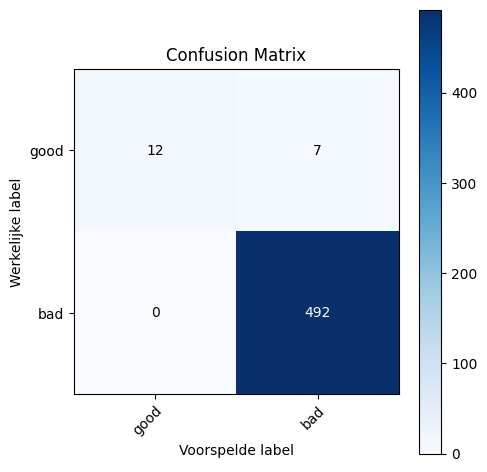

In [22]:
plot_confusion_matrix(y_test, y_pred)